## 43-65

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",num_labels = 3 )

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [15]:
import torch

# 감성 레이블을 숫자로 매칭하는 딕셔너리 준비
dic = {0:'positive', 1:'neutral', 2:'negative'}

# 입력 문장 데이터
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

# 정답 레이블(answer label)
ans = torch.tensor([0, 0, 1, 2, 2, 0])


In [23]:
model.eval()

with torch.no_grad():
    for article in eval_list:
        inputs = tokenizer.encode(article, return_tensors="pt",padding=True,truncation=True)
        outputs = model(inputs)
        logits = outputs.logits
        print(f"{dic[logits.argmax(-1).item()]}:{article}")

positive:I like apple
positive:I like pear
neutral:I go to school
negative:I dislike mosquito
negative:I felt very sad
positive:I feel so good


In [17]:
# 런타임 1분 소요
# 활성화 함수 AdamW 불러오기
from transformers import AdamW

# 활성화 함수 AdamW 인스턴스화
optimizer = AdamW(model.parameters(), lr=1e-5)


# 모델을 학습 모드로 변경
model.train()

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs = 50
losses = []

# 파인튜닝
for epoch in range(epochs):

    # 그래디언트(기울기) 초기화
    optimizer.zero_grad()

    # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
    inputs = tokenizer.batch_encode_plus(eval_list, return_tensors="pt", padding=True, truncation=True)
    
    # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
    # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
    outputs = model(**inputs, labels=ans)

    # 로짓 추출
    logits = outputs.logits

    # 손실 추출
    loss = outputs.loss

    # 오차역전파
    loss.backward()

    # 가중치(weight) 업데이트
    optimizer.step()

    # 손실을 빈 컨테이너 losses에 순서대로 저장
    losses.append(loss)

    # 에포크 및 손실 값 출력
    # 에포크는 0부터 시작하기에, 1을 더해줘서 사람들이 에포크 회수를 더 자연스럽게 인지하게 조치
    print(f"epoch:{epoch+1}, loss:{loss}")


epoch:1, loss:1.005324363708496
epoch:2, loss:1.0017681121826172
epoch:3, loss:0.9301735758781433
epoch:4, loss:1.0353354215621948
epoch:5, loss:1.0601882934570312
epoch:6, loss:1.0591109991073608
epoch:7, loss:0.9373170733451843
epoch:8, loss:0.885542631149292
epoch:9, loss:0.9669885635375977
epoch:10, loss:0.8057706952095032
epoch:11, loss:0.8437663912773132
epoch:12, loss:0.8559024333953857
epoch:13, loss:0.8128001689910889
epoch:14, loss:0.8020715117454529
epoch:15, loss:0.7041707038879395
epoch:16, loss:0.6522318124771118
epoch:17, loss:0.6728578209877014
epoch:18, loss:0.6325636506080627
epoch:19, loss:0.5774747729301453
epoch:20, loss:0.6754273772239685
epoch:21, loss:0.5964720845222473
epoch:22, loss:0.4475818872451782
epoch:23, loss:0.563477098941803
epoch:24, loss:0.4801467955112457
epoch:25, loss:0.5579213500022888
epoch:26, loss:0.522051215171814
epoch:27, loss:0.4860715866088867
epoch:28, loss:0.44378066062927246
epoch:29, loss:0.43595072627067566
epoch:30, loss:0.40372717

In [18]:
inputs# 파이토치에서 item( )은 GPU로부터 값을 추출하여 CPU로 전달
new_losses = [i.item() for i in losses]

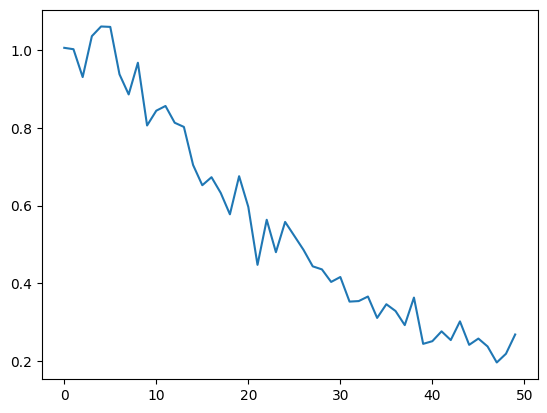

In [21]:
import matplotlib.pyplot as plt
plt.plot(new_losses);


In [22]:
# 파인 튜닝 이후 추론
dic = {0:'positive', 1:'neutral', 2:'negative'}
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for article in eval_list:
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}: {article}")


positive: I like apple
positive: I like pear
neutral: I go to school
negative: I dislike mosquito
negative: I felt very sad
positive: I feel so good


In [25]:

# item()에 의해 넘파이 숫자값이 된 preds를 다시 토치 텐서 타입으로 변환
import torch
preds = torch.tensor(preds)

# preds 출력
print(preds)

# 정답(ans)와 예측(preds)가 일치하는 건수를
# 정답(ans)의 전체 건수로 나누어서 정확도(Accuracy) 계산
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

tensor([0, 0, 1, 2, 2, 0])
Accuracy:100.0%


C:\Users\우승우\AppData\Local\Temp\ipykernel_14180\2938332119.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds)


In [32]:
from transformers import BartTokenizer, BartForConditionalGeneration

# 모델 및 토크나이저 불러오기
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')



config.json: 100%|██████████| 1.63k/1.63k [00:00<?, ?B/s]
pytorch_model.bin: 100%|██████████| 1.02G/1.02G [00:10<00:00, 95.6MB/s]
tokenizer_config.json: 100%|██████████| 26.0/26.0 [00:00<00:00, 26.0kB/s]
vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 1.13MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 768kB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 6.71MB/s]


In [33]:
import re

# 줄이 바뀌는 텍스트를 인용할 경우 인용부호로 """를 사용
article = """
Google LLC is an American multinational technology company focusing on search engine technology, online advertising, cloud computing, computer software, quantum computing, e-commerce, artificial intelligence,[9] and consumer electronics. It has been referred to as "the most powerful company in the world"[10] and one of the world's most valuable brands due to its market dominance, data collection, and technological advantages in the area of artificial intelligence.[11][12][13] Its parent company Alphabet is considered one of the Big Five American information technology companies, alongside Amazon, Apple, Meta, and Microsoft.

Google was founded on September 4, 1998, by Larry Page and Sergey Brin while they were PhD students at Stanford University in California. Together they own about 14% of its publicly listed shares and control 56% of the stockholder voting power through super-voting stock. The company went public via an initial public offering (IPO) in 2004. In 2015, Google was reorganized as a wholly owned subsidiary of Alphabet Inc. Google is Alphabet's largest subsidiary and is a holding company for Alphabet's Internet properties and interests. Sundar Pichai was appointed CEO of Google on October 24, 2015, replacing Larry Page, who became the CEO of Alphabet. On December 3, 2019, Pichai also became the CEO of Alphabet.[14]

The company has since rapidly grown to offer a multitude of products and services beyond Google Search, many of which hold dominant market positions. These products address a wide range of use cases, including email (Gmail), navigation (Waze & Maps), cloud computing (Cloud), web browsing (Chrome), video sharing (YouTube), productivity (Workspace), operating systems (Android), cloud storage (Drive), language translation (Translate), photo storage (Photos), video calling (Meet), smart home (Nest), smartphones (Pixel), wearable technology (Pixel Watch & Fitbit), music streaming (YouTube Music), video on demand (YouTube TV), artificial intelligence (Google Assistant), machine learning APIs (TensorFlow), AI chips (TPU), and more. Discontinued Google products include gaming (Stadia), Glass,[citation needed] Google+, Reader, Play Music, Nexus, Hangouts, and Inbox by Gmail.[15][16]

Google's other ventures outside of Internet services and consumer electronics include quantum computing (Sycamore), self-driving cars (Waymo, formerly the Google Self-Driving Car Project), smart cities (Sidewalk Labs), and transformer models (Google Brain).[17]

Google and YouTube are the two most visited websites worldwide followed by Facebook and Twitter. Google is also the largest search engine, mapping and navigation application, email provider, office suite, video sharing platform, photo and cloud storage provider, mobile operating system, web browser, ML framework, and AI virtual assistant provider in the world as measured by market share. On the list of most valuable brands, Google is ranked second by Forbes[18] and fourth by Interbrand.[19] It has received significant criticism involving issues such as privacy concerns, tax avoidance, censorship, search neutrality, antitrust and abuse of its monopoly position.
"""

print("before:")
print(article)

# 정규식 적용
article = re.sub(r"[:.]\[[0-9]+\](.*?)\([0-9]+\)|.?[([][0-9]+[])]|\n|\r", r"", article)

print("after:")
print(article)


before:

Google LLC is an American multinational technology company focusing on search engine technology, online advertising, cloud computing, computer software, quantum computing, e-commerce, artificial intelligence,[9] and consumer electronics. It has been referred to as "the most powerful company in the world"[10] and one of the world's most valuable brands due to its market dominance, data collection, and technological advantages in the area of artificial intelligence.[11][12][13] Its parent company Alphabet is considered one of the Big Five American information technology companies, alongside Amazon, Apple, Meta, and Microsoft.

Google was founded on September 4, 1998, by Larry Page and Sergey Brin while they were PhD students at Stanford University in California. Together they own about 14% of its publicly listed shares and control 56% of the stockholder voting power through super-voting stock. The company went public via an initial public offering (IPO) in 2004. In 2015, Google 

In [35]:
# 토크나이저로 인코딩
inputs = tokenizer([article], max_length=1024, return_tensors='pt', truncation=True)
inputs


{'input_ids': tensor([[    0, 20441,  2291,    16,    41,   470, 17043,   806,   138,  5650,
            15,  1707,  3819,   806,     6,   804,  4579,     6,  3613, 11730,
             6,  3034,  2257,     6, 17997, 11730,     6,   364,    12,  8342,
             6,  7350,  2316,     8,  2267,  8917,     4,    85,    34,    57,
          4997,     7,    25,    22,   627,   144,  2247,   138,    11,     5,
           232,     8,    65,     9,     5,   232,    18,   144,  5130,  3595,
           528,     7,    63,   210, 12532,     6,   414,  2783,     6,     8,
          9874, 12340,    11,     5,   443,     9,  7350,  2316,  3139,  4095,
           138, 15023,    16,  1687,    65,     9,     5,  1776,  4934,   470,
           335,   806,   451,     6,  2863,  1645,     6,  1257,     6, 37622,
             6,     8,  3709,     4, 20441,    21,  4790,    15,   772,   204,
             6,  6708,     6,    30,  6045,  7086,     8, 23509,  2265,   179,
           150,    51,    58, 15221,  

In [36]:
# 텐서플로우 타입인 inputs['input_ids]를 넘파이 어레이 타입으로 변경
inputs['input_ids'].numpy()


array([[    0, 20441,  2291,    16,    41,   470, 17043,   806,   138,
         5650,    15,  1707,  3819,   806,     6,   804,  4579,     6,
         3613, 11730,     6,  3034,  2257,     6, 17997, 11730,     6,
          364,    12,  8342,     6,  7350,  2316,     8,  2267,  8917,
            4,    85,    34,    57,  4997,     7,    25,    22,   627,
          144,  2247,   138,    11,     5,   232,     8,    65,     9,
            5,   232,    18,   144,  5130,  3595,   528,     7,    63,
          210, 12532,     6,   414,  2783,     6,     8,  9874, 12340,
           11,     5,   443,     9,  7350,  2316,  3139,  4095,   138,
        15023,    16,  1687,    65,     9,     5,  1776,  4934,   470,
          335,   806,   451,     6,  2863,  1645,     6,  1257,     6,
        37622,     6,     8,  3709,     4, 20441,    21,  4790,    15,
          772,   204,     6,  6708,     6,    30,  6045,  7086,     8,
        23509,  2265,   179,   150,    51,    58, 15221,   521,    23,
      

In [39]:
# 런타임 30초 소요
# 문장 요약 생성 결과(vocabulary ID)를 summary_ids에 저장
summary_ids = model.generate(inputs['input_ids'], num_beams=5, max_length=25)
print("Vectors")
print(summary_ids)
# summary_ids 디코딩
print("decoded")
print(''.join([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]))

Vectors
tensor([[    2,     0, 20441,  2291,    16,    41,   470, 17043,   806,   138,
          5650,    15,  1707,  3819,   806,     6,   804,  4579,     6,  3613,
         11730,     6,  3034,  2257,     2]])
decoded
Google LLC is an American multinational technology company focusing on search engine technology, online advertising, cloud computing, computer software


In [40]:
dataset = [["What music do you like?", "I like Rock music.", 1],
           ["What is your favorite food?", "I like sushi the best", 1],
           ["What is your favorite color?", "I'm going to be a doctor", 0],
           ["What is your favorite song?", "Tokyo olympic game in 2020 was postponed", 0],
           ["Do you like watching TV shows?", "Yeah, I often watch it in my spare time", 1]]
from transformers import BertPreTrainedModel, BertConfig, BertModel, BertTokenizer, AdamW
from torch import nn

# 클래스 정의
class BertEnsembleForNextSentencePrediction(BertPreTrainedModel):
  def __init__(self, config, *args, **kwargs):
      super().__init__(config)

      # QA BERT 모델
      self.bert_model_1 = BertModel(config)
      # AQ BERT 모델
      self.bert_model_2 = BertModel(config)

      # 선형함수
      self.cls = nn.Linear(2 * self.config.hidden_size, 2)
      # 초기 가중치
      self.init_weights()

  def forward(
          self,
          input_ids=None,
          attention_mask=None,
          token_type_ids=None,
          position_ids=None,
          head_mask=None,
          inputs_embeds=None,
          next_sentence_label=None,
  ):
    # 빈 컨테이너 변수 outputs 생성
    outputs = []

    # input_ids 첫번째 입력(문장) 저장
    input_ids_1 = input_ids[0]

    # input_ids 첫번째 입력(문장)의 attention_mask 저장
    attention_mask_1 = attention_mask[0]

    # bert_model_1에 input_ids_1 투입한 결과를 outputs에 순차적으로 저장
    outputs.append(self.bert_model_1(input_ids_1,
                                     attention_mask=attention_mask_1))

    # input_ids 두번째 입력(문장) 저장
    input_ids_2 = input_ids[1]

    # input_ids 두번째 입력(문장)의 attention_mask 저장
    attention_mask_2 = attention_mask[1]

    # bert_model_2에 input_ids_2 투입한 결과를 outputs에 순차적으로 저장
    outputs.append(self.bert_model_2(input_ids_2,
                                     attention_mask=attention_mask_2))

    # outputs에 쌓인 output의 두번째 요소(output[1])을 하나하나 끄집어내어
    # torch.cat()로 토치 텐서 형태로 병합
    # 이를 통해 마지막 은닉층 임베딩 상태를 구함
    last_hidden_states = torch.cat([output[1] for output in outputs], dim=1)
    # self.cls 선형함수에 마지막 은닉층 임베딩 상태를 투입하여 로짓 추출
    logits = self.cls(last_hidden_states)

    # 크로스엔트로피 손실(crossentropyloss) 구하기
    # crossentropyloss: https://pytorch.org/docs/stable/nn.html#crossentropyloss
    if next_sentence_label is not None:
      # nn.CrossEntropyLoss( ) 입력 데이터의 마지막 인덱스는 계산에서 제외
      loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
      # logits.view(-1,2)는 열이 두 개 형태로 logits를 정렬
      # next_sentence_label.view(-1)는 행이 하나인 형태(flattening)로 정렬
      next_sentence_loss = loss_fct(logits.view(-1, 2), next_sentence_label.view(-1))
      return next_sentence_loss, logits
    else:
      return logits


+ view(-1)

In [44]:
x = torch.randint(0,10,(2,3))
print(x)
print(x.view(6,-1))
print(x.view(-1))

tensor([[2, 9, 4],
        [8, 6, 6]])
tensor([[2],
        [9],
        [4],
        [8],
        [6],
        [6]])
tensor([2, 9, 4, 8, 6, 6])


In [45]:
import torch
from transformers import AdamW

# 코랩에서 가능한 경우 GPU를 사용하고, 그렇지 않으면 CPU 사용하도록
# 변수 device로 설정을 저장
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 및 config 설정
config = BertConfig()
model = BertEnsembleForNextSentencePrediction(config)

# 모델을 변수 device에서 설정한 대로 GPU 혹은 CPU로 전송
model.to(device)

# 토크니이저 불러오기
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

# 학습률 설정
learning_rate = 1e-5

# 절편과 가중치를 no_decay 변수에 저장
no_decay = ["bias", "LayerNorm.weight"]

# 최적화 함수 그룹 파라미터 설정
optimizer_grouped_parameters = [{
  "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
  }]

# 최적화 함수 설정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)


c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [46]:
#함수 prepare_data 정의
def prepare_data(dataset, qa=True):

  # 빈 컨테이너 변수 생성
  input_ids, attention_masks = [], []
  labels = []

  for point in dataset:
    if qa is True:
      # point에 있는 3개의 원소를 앞에 요소부터 q, a, _ 으로 배정
      q, a, _ = point
    else:
      # point에 있는 3개의 원소를 앞에 요소부터 a, q, _ 으로 배정
      a, q, _ = point
    # q와 a를 토크나이저를 통해 인코딩
    encoded_dict = tokenizer.encode_plus(
      q,  # 문장 1 인코딩
      a,  # 문장 2 인코딩
      add_special_tokens=True,  # 특수 토큰인 [CLS]와 [SEP] 생성
      max_length=128,           # max_length 설정Pad & truncate all sentences.
      pad_to_max_length=True,   # max_length까지 패딩 실행
      return_attention_mask=True,  # attention_mask 생성
      return_tensors='pt',      # 파이토치 텐서 타입으로 출력
      truncation=True           # truncation 실행
    )

    # encoded_dict("input_ids")를 컨테이너 변수 input_ids에 순서대로 저장
    input_ids.append(encoded_dict["input_ids"])
    # encoded_dict("attention_mask")를 컨테이너 변수 attention_mask에 순서대로 저장
    attention_masks.append(encoded_dict["attention_mask"])
    # point의 마지막(세번째) 요소(레이블)을 컨테이너 변수 labels에 순서대로 저장
    labels.append(point[-1])
    # 반복문 종료

  # input_ids를 첫번째 축(dim=0), 즉 세로 방향으로 병합
  input_ids = torch.cat(input_ids, dim=0)

  # attention_mask를 첫번째 축(dim=0), 즉 세로 방향으로 병합
  attention_masks = torch.cat(attention_masks, dim=0)

  # 함수의 결과물로 input_ids, attention_mask, lables 출력
  return input_ids, attention_masks, labels


In [47]:
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, Dataset, SequentialSampler

# QADataset 클래스 생성
class QADataset(Dataset):

  # input_ids 텐서와 attention_masks 텐서 생성
  def __init__(self, input_ids, attention_masks, labels=None):
    self.input_ids = np.array(input_ids)
    self.attention_masks = np.array(attention_masks)
    # toch.long은 정수(integer) 타입을 의미
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __getitem__(self, index):
    return self.input_ids[index], self.attention_masks[index], self.labels[index]

  def __len__(self):
    return self.input_ids.shape[0]


In [48]:
# dataset을 prepare_data 함수에 투입하여 그 결과를 각기
# input_ids_qa, attention_maskes_qa, labels_qa에 저장
input_ids_qa, attention_masks_qa, labels_qa = prepare_data(dataset)

# 위의 세 결과물을 QADataset 클래스에 투입
train_dataset_qa = QADataset(input_ids_qa, attention_masks_qa, labels_qa)

# 맨 윗줄 코드와 동일하나 이번에는 prepare_data 함수에 qa 플래그 값이 False일 때를 적용
input_ids_aq, attention_masks_aq, labels_aq = prepare_data(dataset, qa=False)

# 바로 위 세 결과물을 QADataset 클래스에 투입
train_dataset_aq = QADataset(input_ids_aq, attention_masks_aq, labels_aq)

# train_dataset_qa를 DataLoader로 처리
dataloader_qa =  DataLoader(dataset=train_dataset_qa,
                            batch_size=5,
                            sampler=SequentialSampler(train_dataset_qa))
# train_dataset_aq를 DataLoader로 처리
dataloader_aq =  DataLoader(dataset=train_dataset_aq,
                            batch_size=5,
                            sampler=SequentialSampler(train_dataset_aq))


c:\ProgramData\anaconda3\envs\transformer\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [49]:
# 런타임 20, 30초 이내, 단 GPU 미사용시 런타임 약 8분 소요
# 에포크 횟수 지정
epochs = 30

# 에포크 횟수만큼 반복 루프 실행
for epoch in range(epochs):

  # dataloader_qa와 datalaode_aq 쌍(pair)를 동시에 반복 루프에서 처리
  # enumerate 및 zip으로 두 데이터 쌍을 묶고 반복가능한 순서 부여
  # zip은 반복가능한 객체를 받아 원소를 튜플로 변환
  for step, combined_batch in enumerate(zip(dataloader_qa, dataloader_aq)):
    # enumerate로 묶은 두 데이터쌍을 순서대로 batch_1과 batch_2에 저장
    batch_1, batch_2 = combined_batch
    #모델을 학습 모드로 전환
    model.train()

    # 가능한 경우 batch_1과 batch_2의 데이터를 GPU로 전달하고
    # 그렇지 않은 경우 CPU로 전달
    batch_1 = tuple(t.to(device) for t in batch_1)
    batch_2 = tuple(t.to(device) for t in batch_2)

    # 모델에 투입할 변수 inputs의 내용 입력
    inputs = {
        "input_ids": [batch_1[0], batch_2[0]],
        "attention_mask": [batch_1[1], batch_2[1]],
        "next_sentence_label": batch_1[2]
    }
    # 모델에 inputs를 **kwargs 형식(**inputs로 표기)으로 투입
    # 즉, 딕셔너리 타입인 inputs의 키(key)와 키값(value) 모두 입력
    outputs = model(**inputs)

    # 모델의 결과물인 outputs는 튜플 타입으로 출력
    # 그중 첫번째 요소, 즉 outputs[0]을 변수 loss에 저장
    loss = outputs[0]
    # 오차 역전파
    loss.backward()
    # f 문자열을 사용하여 에포크와 손실 출력
    print(f"epoch:{epoch}, loss:{loss}")

    # 가중치 업데이트
    optimizer.step()
    # 다음 번 에포크를 위해 그래디언트(기울기) 초기화
    model.zero_grad()


epoch:0, loss:0.7840352058410645
epoch:1, loss:0.7113007307052612
epoch:2, loss:0.6796483397483826
epoch:3, loss:0.5578693151473999
epoch:4, loss:0.5462298393249512
epoch:5, loss:0.49122634530067444
epoch:6, loss:0.46497970819473267
epoch:7, loss:0.5190169215202332
epoch:8, loss:0.42059651017189026
epoch:9, loss:0.3347664773464203
epoch:10, loss:0.4123448431491852
epoch:11, loss:0.27292197942733765
epoch:12, loss:0.293318510055542
epoch:13, loss:0.23840391635894775
epoch:14, loss:0.2577614188194275
epoch:15, loss:0.20953114330768585
epoch:16, loss:0.18924881517887115
epoch:17, loss:0.1678706705570221
epoch:18, loss:0.12091512978076935
epoch:19, loss:0.08506893366575241
epoch:20, loss:0.0719650462269783
epoch:21, loss:0.05616874620318413
epoch:22, loss:0.056133974343538284
epoch:23, loss:0.027188073843717575
epoch:24, loss:0.035054296255111694
epoch:25, loss:0.01944793201982975
epoch:26, loss:0.01767650805413723
epoch:27, loss:0.02308240719139576
epoch:28, loss:0.013324430212378502
epoc

In [50]:
# dataset을 prepare_data 함수로 처리
input_ids_qa, attention_masks_qa, labels_qa = prepare_data(dataset)
# 위 결과물을 QADataset 클래스로 처리
test_dataset_qa = QADataset(input_ids_qa, attention_masks_qa, labels_qa)

# dataset을 prepare_data 함수로 처리하되 qa 플래그를 False로 적용
input_ids_aq, attention_masks_aq, labels_aq = prepare_data(dataset, qa=False)
# 위 결과물을 QADataset 클래스로 처리
test_dataset_aq = QADataset(input_ids_aq, attention_masks_aq, labels_aq)

# test_dataset_qa를 DataLoader로 처리
dataloader_qa =  DataLoader(dataset=test_dataset_qa,
                            batch_size=16,
                            sampler=SequentialSampler(test_dataset_qa))
# test_dataset_aq를 DataLoader로 처리
dataloader_aq =  DataLoader(dataset=test_dataset_aq,
                            batch_size=16,
                            sampler=SequentialSampler(test_dataset_aq))

# 결과를 담을 빈 컨테이너로서 리스트 변수 생성
complete_outputs, complete_label_ids = [], []

# dataloader_qa와 dataloade_aq를 동시에 반복 루프 작업 실시

for step, combined_batch in enumerate(zip(dataloader_qa, dataloader_aq)):

  # 모델을 eval 모드로 전환
  model.eval()
  # enumerate로 묶은 두 데이터 쌍을 순서대로 batch_1과 batch_2에 저장
  batch_1, batch_2 = combined_batch

  # 가능한 경우 batch_1과 batch2의 데이터를 GPU로 전달하고
  # 그렇지 않은 경우 CPU로 전달
  batch_1 = tuple(t.to(device) for t in batch_1)
  batch_2 = tuple(t.to(device) for t in batch_2)

  # 추론(evaluation) 때는 순전파(forward propagation) 과정만 필요하기에
  # 그래디언트(기울기) 계산이 필요 없음. 아래 코딩 줄은 자동미분을 방지.
  with torch.no_grad():

    # 모델에 투입할 변수 inputs의 내용 입력
    inputs = {
        "input_ids": [batch_1[0], batch_2[0]],
        "attention_mask": [batch_1[1], batch_2[1]],
        "next_sentence_label": batch_1[2]
    }

    # 모델에 inputs를 **kwargs 형식(**inputs로 표기)으로 투입
    # 즉, 딕셔너리 타입인 inputs의 키(key)와 키값(value) 모두 입력
    outputs = model(**inputs)

    # outputs의 첫번째 요소를 tmp_eval_loss에 저장
    # outputs의 두번째 요소를 logits에 저장
    tmp_eval_loss, logits = outputs[:2]

    # 로짓을 CPU로 전달하고 넘파이 값으로 변환
    logits = logits.detach().cpu().numpy()
    # logits에 담긴 로짓값을 축(axis) 1, 즉 가로방향으로 최대값을 갖는 인덱스 추출
    outputs = np.argmax(logits, axis=1)
    # inputs['next_sentence_label']을 CPU로 전달하고 넘파이 값으로 변환
    label_ids = inputs["next_sentence_label"].detach().cpu().numpy()
    # with torch.no_grad(): 구문 종료

  # outputs과 label_ids를 각각의 컨테이너 리스트 변수에 순서대로 저장
  complete_outputs.extend(outputs)
  complete_label_ids.extend(label_ids)

# 최종 결과물 출력
print(complete_outputs, complete_label_ids)


[1, 1, 0, 0, 1] [1, 1, 0, 0, 1]


In [51]:
# 이 코드의 설명은 앞의 문제들 주석과 동일
dataset = [["What music do you like?", "I like Rock music.", 1]]

input_ids_qa, attention_masks_qa, labels_qa = prepare_data(dataset)
test_dataset_qa = QADataset(input_ids_qa, attention_masks_qa, labels_qa)

input_ids_aq, attention_masks_aq, labels_aq = prepare_data(dataset, qa=False)
test_dataset_aq = QADataset(input_ids_aq, attention_masks_aq, labels_aq)

dataloader_qa =  DataLoader(dataset=test_dataset_qa,
                            batch_size=16,
                            sampler=SequentialSampler(test_dataset_qa))
dataloader_aq =  DataLoader(dataset=test_dataset_aq,
                            batch_size=16,
                            sampler=SequentialSampler(test_dataset_aq))

complete_outputs, complete_label_ids = [], []

for step, combined_batch in enumerate(zip(dataloader_qa, dataloader_aq)):
  model.eval()
  batch_1, batch_2 = combined_batch

  batch_1 = tuple(t.to(device) for t in batch_1)
  batch_2 = tuple(t.to(device) for t in batch_2)

  with torch.no_grad():
    inputs = {
        "input_ids": [batch_1[0], batch_2[0]],
        "attention_mask": [batch_1[1], batch_2[1]],
        "next_sentence_label": batch_1[2]
    }
    outputs = model(**inputs)
    tmp_eval_loss, logits = outputs[:2]
    logits = logits.detach().cpu().numpy()
    outputs = np.argmax(logits, axis=1)
    label_ids = inputs["next_sentence_label"].detach().cpu().numpy()
  complete_outputs.extend(outputs)
  complete_label_ids.extend(label_ids)

print(complete_outputs, complete_label_ids)


[1] [1]
